# GameTheory-15 : Apprentissage par Renforcement Multi-Agent

## Self-Play, NFSP et PSRO

Ce notebook explore l'intersection entre la theorie des jeux et l'apprentissage par renforcement (RL) dans les environnements multi-agents.

**Objectifs pedagogiques** :
- Comprendre les defis specifiques du MARL (Multi-Agent RL)
- Maitriser le concept de self-play et ses variantes
- Implementer Fictitious Play et ses extensions neurales (NFSP)
- Decouvrir PSRO (Policy-Space Response Oracles)

**Prerequis** : Notebooks 1-14, notions de base en RL

**Duree estimee** : 55 minutes

---

## 1. Defis du Multi-Agent RL

### 1.1 Pourquoi le MARL est difficile

| Defi | Description |
|------|-------------|
| **Non-stationnarite** | L'environnement change car les autres agents apprennent |
| **Credit assignment** | Difficult de savoir qui est responsable du resultat |
| **Espace d'action conjoint** | Explose exponentiellement avec le nombre d'agents |
| **Equilibres multiples** | Plusieurs Nash possibles, convergence incertaine |
| **Exploration** | Coordination implicite necessaire |

### 1.2 Approches principales

1. **Independent Learning** : chaque agent apprend comme si les autres etaient statiques
2. **Self-Play** : l'agent joue contre des versions de lui-meme
3. **Population-based Training** : ensemble d'agents qui co-evoluent
4. **Centralized Training, Decentralized Execution** (CTDE)

### 1.3 Objectifs d'apprentissage

- **Jeux a somme nulle** : trouver un equilibre de Nash
- **Jeux cooperatifs** : maximiser le gain collectif
- **Jeux generaux** : trouver un equilibre stable

In [1]:
# Installation des dependances
import subprocess
import sys

packages = ['numpy', 'matplotlib', 'tqdm']
for pkg in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', pkg])

# Tentative OpenSpiel
try:
    import pyspiel
    OPENSPIEL_AVAILABLE = True
except ImportError:
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'open_spiel'])
        import pyspiel
        OPENSPIEL_AVAILABLE = True
    except:
        OPENSPIEL_AVAILABLE = False
        print("OpenSpiel non disponible - utilisation des implementations locales")

import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional, Callable
from collections import defaultdict
from dataclasses import dataclass
from abc import ABC, abstractmethod
from tqdm import tqdm

print("Imports reussis")
print(f"OpenSpiel disponible: {OPENSPIEL_AVAILABLE}")

Imports reussis
OpenSpiel disponible: True


## 2. Self-Play : Apprentissage par Auto-Competition

### 2.1 Principe

Au lieu d'avoir un adversaire fixe, l'agent joue contre :
- Lui-meme (self-play naif)
- Des versions anterieures (historical self-play)
- Un melange (fictitious self-play)

### 2.2 Problemes du self-play naif

- **Forgetting catastrophique** : oublie comment battre les anciennes strategies
- **Cycles** : oscillations entre strategies non-transitives (RPS)
- **Exploitation locale** : sur-optimise contre la version courante

### 2.3 AlphaGo/AlphaZero

Succes spectaculaire du self-play avec MCTS + reseaux de neurones dans les jeux a information parfaite.

In [2]:
class MatrixGame:
    """Jeu matriciel a 2 joueurs."""
    
    def __init__(self, payoff_matrix_p1: np.ndarray, name: str = "Game"):
        """
        payoff_matrix_p1[i, j] = payoff de P1 si P1 joue i et P2 joue j.
        Jeu a somme nulle : payoff P2 = -payoff P1.
        """
        self.A = payoff_matrix_p1
        self.name = name
        self.n_actions_p1 = self.A.shape[0]
        self.n_actions_p2 = self.A.shape[1]
    
    def get_payoff(self, action_p1: int, action_p2: int) -> Tuple[float, float]:
        """Retourne (payoff P1, payoff P2)."""
        p1 = self.A[action_p1, action_p2]
        return (p1, -p1)
    
    def expected_payoff(self, strategy_p1: np.ndarray, 
                        strategy_p2: np.ndarray) -> Tuple[float, float]:
        """Payoff espere pour des strategies mixtes."""
        p1 = strategy_p1 @ self.A @ strategy_p2
        return (p1, -p1)
    
    def best_response(self, opponent_strategy: np.ndarray, 
                      player: int) -> np.ndarray:
        """Meilleure reponse pure a une strategie mixte adverse."""
        if player == 0:  # P1
            payoffs = self.A @ opponent_strategy
            best_action = np.argmax(payoffs)
            br = np.zeros(self.n_actions_p1)
            br[best_action] = 1.0
        else:  # P2 (minimise payoff P1)
            payoffs = self.A.T @ opponent_strategy
            best_action = np.argmin(payoffs)  # Min car somme nulle
            br = np.zeros(self.n_actions_p2)
            br[best_action] = 1.0
        return br
    
    def exploitability(self, strategy_p1: np.ndarray, 
                       strategy_p2: np.ndarray) -> float:
        """
        Mesure de la distance a l'equilibre de Nash.
        
        = gain max de P1 en deviant + gain max de P2 en deviant
        """
        # Meilleure reponse de P1
        br_p1 = self.best_response(strategy_p2, 0)
        gain_p1 = self.expected_payoff(br_p1, strategy_p2)[0] - \
                  self.expected_payoff(strategy_p1, strategy_p2)[0]
        
        # Meilleure reponse de P2
        br_p2 = self.best_response(strategy_p1, 1)
        gain_p2 = self.expected_payoff(strategy_p1, br_p2)[1] - \
                  self.expected_payoff(strategy_p1, strategy_p2)[1]
        
        return gain_p1 + gain_p2


# Jeux classiques
def create_rps() -> MatrixGame:
    """Rock-Paper-Scissors."""
    A = np.array([
        [0, -1, 1],   # Rock
        [1, 0, -1],   # Paper
        [-1, 1, 0]    # Scissors
    ])
    return MatrixGame(A, "Rock-Paper-Scissors")


def create_matching_pennies() -> MatrixGame:
    """Matching Pennies."""
    A = np.array([
        [1, -1],   # Heads
        [-1, 1]    # Tails
    ])
    return MatrixGame(A, "Matching Pennies")


# Test
rps = create_rps()
print(f"Jeu: {rps.name}")
print(f"Matrice de gains P1:")
print(rps.A)

# Equilibre de Nash = (1/3, 1/3, 1/3)
nash = np.array([1/3, 1/3, 1/3])
print(f"\nExploitabilite a Nash: {rps.exploitability(nash, nash):.6f}")

Jeu: Rock-Paper-Scissors
Matrice de gains P1:
[[ 0 -1  1]
 [ 1  0 -1]
 [-1  1  0]]

Exploitabilite a Nash: 0.000000


Self-Play Naif sur Rock-Paper-Scissors

Strategie finale P1: [0.40460089 0.39714467 0.19825444]
Strategie finale P2: [0.40460089 0.39714467 0.19825444]
Exploitabilite finale: 0.4127


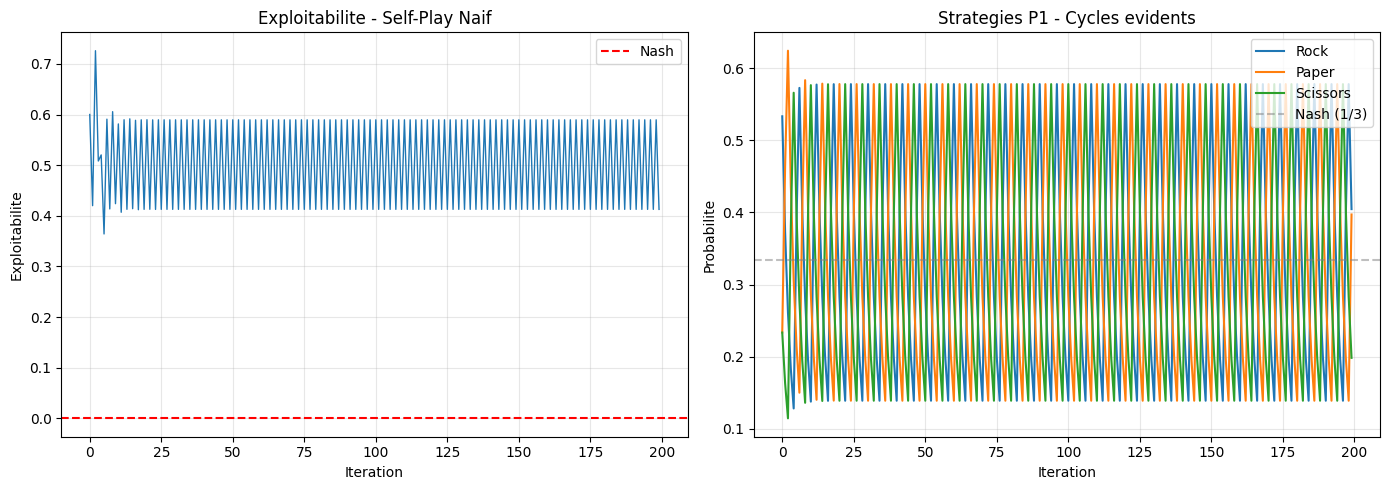


-> Le self-play naif oscille sans converger vers Nash!


In [3]:
class NaiveSelfPlay:
    """
    Self-play naif : chaque joueur optimise contre la strategie
    courante de l'adversaire.
    """
    
    def __init__(self, game: MatrixGame, learning_rate: float = 0.1):
        self.game = game
        self.lr = learning_rate
        
        # Strategies initiales uniformes
        self.strategy_p1 = np.ones(game.n_actions_p1) / game.n_actions_p1
        self.strategy_p2 = np.ones(game.n_actions_p2) / game.n_actions_p2
        
        self.history = {
            'exploitability': [],
            'strategy_p1': [],
            'strategy_p2': []
        }
    
    def step(self):
        """Une iteration de self-play naif."""
        # Meilleure reponse de chaque joueur
        br_p1 = self.game.best_response(self.strategy_p2, 0)
        br_p2 = self.game.best_response(self.strategy_p1, 1)
        
        # Mise a jour graduelle (moving average)
        self.strategy_p1 = (1 - self.lr) * self.strategy_p1 + self.lr * br_p1
        self.strategy_p2 = (1 - self.lr) * self.strategy_p2 + self.lr * br_p2
        
        # Normaliser
        self.strategy_p1 /= self.strategy_p1.sum()
        self.strategy_p2 /= self.strategy_p2.sum()
        
        # Enregistrer
        self.history['exploitability'].append(
            self.game.exploitability(self.strategy_p1, self.strategy_p2)
        )
        self.history['strategy_p1'].append(self.strategy_p1.copy())
        self.history['strategy_p2'].append(self.strategy_p2.copy())
    
    def train(self, iterations: int):
        """Entraine pendant n iterations."""
        for _ in range(iterations):
            self.step()


# Demonstration : self-play naif sur RPS
print("Self-Play Naif sur Rock-Paper-Scissors")
print("="*50)

rps = create_rps()
sp_naive = NaiveSelfPlay(rps, learning_rate=0.3)
sp_naive.train(200)

print(f"\nStrategie finale P1: {sp_naive.strategy_p1}")
print(f"Strategie finale P2: {sp_naive.strategy_p2}")
print(f"Exploitabilite finale: {sp_naive.history['exploitability'][-1]:.4f}")

# Visualisation des cycles
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Exploitabilite
ax1 = axes[0]
ax1.plot(sp_naive.history['exploitability'], linewidth=1)
ax1.axhline(y=0, color='r', linestyle='--', label='Nash')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Exploitabilite')
ax1.set_title('Exploitabilite - Self-Play Naif')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Evolution des strategies
ax2 = axes[1]
strategies = np.array(sp_naive.history['strategy_p1'])
for i, label in enumerate(['Rock', 'Paper', 'Scissors']):
    ax2.plot(strategies[:, i], label=label)
ax2.axhline(y=1/3, color='gray', linestyle='--', alpha=0.5, label='Nash (1/3)')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Probabilite')
ax2.set_title('Strategies P1 - Cycles evidents')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('naive_selfplay_rps.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n-> Le self-play naif oscille sans converger vers Nash!")

## 3. Fictitious Play

### 3.1 Principe (Brown, 1951)

Chaque joueur :
1. Maintient une estimation de la strategie adverse (moyenne empirique)
2. Joue la meilleure reponse a cette estimation

### 3.2 Convergence

- Converge vers Nash dans les jeux a somme nulle
- Converge dans les jeux a 2 joueurs avec somme constante
- Peut ne pas converger dans les jeux generaux

### 3.3 Avantages

- Simple a implementer
- Garanties theoriques dans certaines classes de jeux
- Base pour des methodes plus sophistiquees (NFSP)

Fictitious Play sur Rock-Paper-Scissors

Strategie moyenne P1: [0.32803181 0.34791252 0.32405567]
Strategie moyenne P2: [0.32803181 0.34791252 0.32405567]
Exploitabilite finale: 0.039761


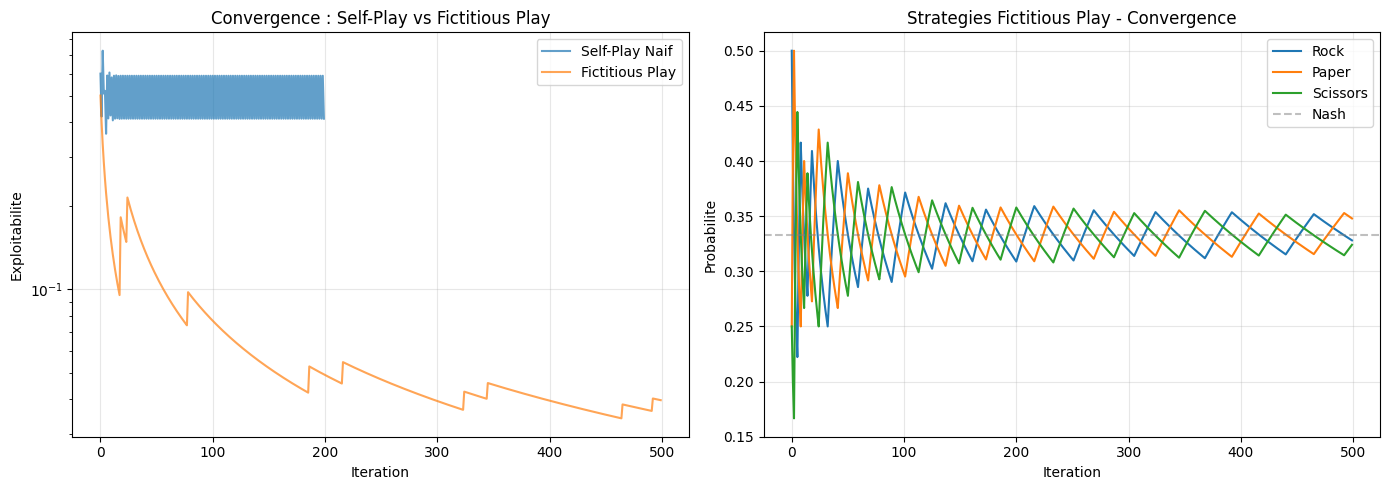


-> Fictitious Play converge vers Nash!


In [4]:
class FictitiousPlay:
    """
    Fictitious Play : joue la meilleure reponse a la
    strategie moyenne historique de l'adversaire.
    """
    
    def __init__(self, game: MatrixGame):
        self.game = game
        
        # Compteurs d'actions jouees
        self.counts_p1 = np.ones(game.n_actions_p1)  # Laplace smoothing
        self.counts_p2 = np.ones(game.n_actions_p2)
        
        self.history = {
            'exploitability': [],
            'avg_strategy_p1': [],
            'avg_strategy_p2': []
        }
    
    def get_average_strategy(self, player: int) -> np.ndarray:
        """Retourne la strategie moyenne (frequence empirique)."""
        if player == 0:
            return self.counts_p1 / self.counts_p1.sum()
        else:
            return self.counts_p2 / self.counts_p2.sum()
    
    def step(self):
        """Une iteration de Fictitious Play."""
        # Strategies moyennes adverses
        avg_p1 = self.get_average_strategy(0)
        avg_p2 = self.get_average_strategy(1)
        
        # Meilleures reponses aux moyennes
        br_p1 = self.game.best_response(avg_p2, 0)
        br_p2 = self.game.best_response(avg_p1, 1)
        
        # Action jouee = argmax de la meilleure reponse
        action_p1 = np.argmax(br_p1)
        action_p2 = np.argmax(br_p2)
        
        # Mettre a jour les compteurs
        self.counts_p1[action_p1] += 1
        self.counts_p2[action_p2] += 1
        
        # Enregistrer
        new_avg_p1 = self.get_average_strategy(0)
        new_avg_p2 = self.get_average_strategy(1)
        
        self.history['exploitability'].append(
            self.game.exploitability(new_avg_p1, new_avg_p2)
        )
        self.history['avg_strategy_p1'].append(new_avg_p1.copy())
        self.history['avg_strategy_p2'].append(new_avg_p2.copy())
    
    def train(self, iterations: int):
        for _ in range(iterations):
            self.step()


# Comparaison avec Self-Play naif
print("Fictitious Play sur Rock-Paper-Scissors")
print("="*50)

fp = FictitiousPlay(rps)
fp.train(500)

print(f"\nStrategie moyenne P1: {fp.get_average_strategy(0)}")
print(f"Strategie moyenne P2: {fp.get_average_strategy(1)}")
print(f"Exploitabilite finale: {fp.history['exploitability'][-1]:.6f}")

# Comparaison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Exploitabilite comparee
ax1 = axes[0]
ax1.plot(sp_naive.history['exploitability'][:500], label='Self-Play Naif', alpha=0.7)
ax1.plot(fp.history['exploitability'], label='Fictitious Play', alpha=0.7)
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Exploitabilite')
ax1.set_title('Convergence : Self-Play vs Fictitious Play')
ax1.legend()
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Evolution des strategies FP
ax2 = axes[1]
strategies = np.array(fp.history['avg_strategy_p1'])
for i, label in enumerate(['Rock', 'Paper', 'Scissors']):
    ax2.plot(strategies[:, i], label=label)
ax2.axhline(y=1/3, color='gray', linestyle='--', alpha=0.5, label='Nash')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Probabilite')
ax2.set_title('Strategies Fictitious Play - Convergence')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fictitious_play_rps.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n-> Fictitious Play converge vers Nash!")

## 4. Neural Fictitious Self-Play (NFSP)

### 4.1 Motivation (Heinrich & Silver, 2016)

Fictitious Play necessite de stocker tout l'historique. NFSP utilise des reseaux de neurones pour :
1. **Approximer la meilleure reponse** (RL network)
2. **Approximer la strategie moyenne** (Supervised Learning network)

### 4.2 Architecture

```
+-------------------+     +-------------------+
|   RL Network      |     |   SL Network      |
|   (Best Response) |     |   (Avg Strategy)  |
+--------+----------+     +--------+----------+
         |                         |
         v                         v
    Q(s, a)                    pi(a|s)
         |                         |
         +------------+------------+
                      |
                      v
              epsilon-greedy:
              eta * pi + (1-eta) * BR(Q)
```

### 4.3 Resultats

- Premier algorithme RL a approximer l'equilibre de Nash au Heads-Up Limit Hold'em
- Base pour des approches plus avancees

In [5]:
class SimplifiedNFSP:
    """
    Version simplifiee de NFSP pour jeux matriciels.
    
    Utilise des tables au lieu de reseaux de neurones.
    """
    
    def __init__(self, game: MatrixGame, 
                 eta: float = 0.1,        # Prob d'utiliser avg strategy
                 rl_lr: float = 0.01,     # Learning rate RL
                 sl_lr: float = 0.01):    # Learning rate SL
        self.game = game
        self.eta = eta
        self.rl_lr = rl_lr
        self.sl_lr = sl_lr
        
        # Q-values pour best response (RL)
        self.Q_p1 = np.zeros(game.n_actions_p1)
        self.Q_p2 = np.zeros(game.n_actions_p2)
        
        # Strategie moyenne (SL)
        self.avg_strategy_p1 = np.ones(game.n_actions_p1) / game.n_actions_p1
        self.avg_strategy_p2 = np.ones(game.n_actions_p2) / game.n_actions_p2
        
        self.history = {
            'exploitability': [],
            'avg_strategy_p1': [],
            'avg_strategy_p2': []
        }
    
    def get_action_p1(self, use_avg: bool) -> int:
        """Selectionne une action pour P1."""
        if use_avg:
            return np.random.choice(self.game.n_actions_p1, p=self.avg_strategy_p1)
        else:
            return np.argmax(self.Q_p1)  # Best response
    
    def get_action_p2(self, use_avg: bool) -> int:
        """Selectionne une action pour P2."""
        if use_avg:
            return np.random.choice(self.game.n_actions_p2, p=self.avg_strategy_p2)
        else:
            return np.argmin(self.Q_p2)  # Min car P2 minimise
    
    def step(self):
        """Une iteration de NFSP."""
        # Decider si on utilise avg strategy ou best response
        use_avg_p1 = np.random.random() < self.eta
        use_avg_p2 = np.random.random() < self.eta
        
        # Jouer
        action_p1 = self.get_action_p1(use_avg_p1)
        action_p2 = self.get_action_p2(use_avg_p2)
        
        # Obtenir les payoffs
        payoff_p1, payoff_p2 = self.game.get_payoff(action_p1, action_p2)
        
        # Mise a jour Q-values (RL - contre la strategie moyenne adverse)
        # Pour P1 : Q[a] = E[payoff | a, opponent plays avg]
        expected_payoffs_p1 = self.game.A @ self.avg_strategy_p2
        self.Q_p1 = (1 - self.rl_lr) * self.Q_p1 + self.rl_lr * expected_payoffs_p1
        
        expected_payoffs_p2 = -self.game.A.T @ self.avg_strategy_p1  # Negatif car somme nulle
        self.Q_p2 = (1 - self.rl_lr) * self.Q_p2 + self.rl_lr * expected_payoffs_p2
        
        # Mise a jour strategie moyenne (SL - supervised vers best response)
        br_p1 = np.zeros(self.game.n_actions_p1)
        br_p1[np.argmax(self.Q_p1)] = 1.0
        self.avg_strategy_p1 = (1 - self.sl_lr) * self.avg_strategy_p1 + self.sl_lr * br_p1
        self.avg_strategy_p1 /= self.avg_strategy_p1.sum()
        
        br_p2 = np.zeros(self.game.n_actions_p2)
        br_p2[np.argmin(self.Q_p2)] = 1.0
        self.avg_strategy_p2 = (1 - self.sl_lr) * self.avg_strategy_p2 + self.sl_lr * br_p2
        self.avg_strategy_p2 /= self.avg_strategy_p2.sum()
        
        # Enregistrer
        self.history['exploitability'].append(
            self.game.exploitability(self.avg_strategy_p1, self.avg_strategy_p2)
        )
        self.history['avg_strategy_p1'].append(self.avg_strategy_p1.copy())
        self.history['avg_strategy_p2'].append(self.avg_strategy_p2.copy())
    
    def train(self, iterations: int):
        for _ in range(iterations):
            self.step()


# Test NFSP
print("Neural Fictitious Self-Play (simplifie) sur RPS")
print("="*50)

nfsp = SimplifiedNFSP(rps, eta=0.1, rl_lr=0.05, sl_lr=0.01)
nfsp.train(1000)

print(f"\nStrategie moyenne P1: {nfsp.avg_strategy_p1}")
print(f"Strategie moyenne P2: {nfsp.avg_strategy_p2}")
print(f"Exploitabilite finale: {nfsp.history['exploitability'][-1]:.6f}")

Neural Fictitious Self-Play (simplifie) sur RPS

Strategie moyenne P1: [6.69996720e-01 3.29988890e-01 1.43904158e-05]
Strategie moyenne P2: [6.69996720e-01 1.43904158e-05 3.29988890e-01]
Exploitabilite finale: 1.009990


## 5. Policy-Space Response Oracles (PSRO)

### 5.1 Motivation (Lanctot et al., 2017)

Au lieu d'une seule strategie, maintenir une **population** de strategies et calculer un equilibre sur cette population.

### 5.2 Algorithme

1. Initialiser avec une population de strategies $\Pi = \{\pi_1\}$
2. Repeter :
   a. Calculer le meta-jeu (payoffs entre toutes les strategies)
   b. Trouver l'equilibre du meta-jeu (meta-Nash)
   c. Entrainer une meilleure reponse a la distribution meta-Nash
   d. Ajouter la nouvelle strategie a la population

### 5.3 Variantes

- **Double Oracle** : PSRO avec best response exacte
- **Alpha-PSRO** : meilleure reponse approximative (RL)
- **DCH** : meta-solver utilisant Hedge au lieu de Nash

In [6]:
class PSRO:
    """
    Policy-Space Response Oracles pour jeux matriciels.
    
    Maintient une population de strategies et calcule des
    equilibres sur le meta-jeu.
    """
    
    def __init__(self, game: MatrixGame):
        self.game = game
        
        # Population de strategies (chaque ligne est une strategie mixte)
        # Initialiser avec strategie uniforme
        self.population_p1 = [np.ones(game.n_actions_p1) / game.n_actions_p1]
        self.population_p2 = [np.ones(game.n_actions_p2) / game.n_actions_p2]
        
        # Meta-game payoff matrix
        self.meta_game = np.zeros((1, 1))
        self._update_meta_game()
        
        self.history = {
            'population_size': [],
            'exploitability': [],
            'meta_nash_p1': [],
            'meta_nash_p2': []
        }
    
    def _update_meta_game(self):
        """Recalcule la matrice du meta-jeu."""
        n1 = len(self.population_p1)
        n2 = len(self.population_p2)
        self.meta_game = np.zeros((n1, n2))
        
        for i, pi1 in enumerate(self.population_p1):
            for j, pi2 in enumerate(self.population_p2):
                payoff, _ = self.game.expected_payoff(pi1, pi2)
                self.meta_game[i, j] = payoff
    
    def _solve_meta_nash(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Resout l'equilibre de Nash du meta-jeu.
        
        Utilise une approximation par support enumeration simplifie.
        """
        n1 = len(self.population_p1)
        n2 = len(self.population_p2)
        
        # Approximation simple : fictitious play sur le meta-jeu
        meta_game_obj = MatrixGame(self.meta_game, "meta")
        fp = FictitiousPlay(meta_game_obj)
        fp.train(100)
        
        return fp.get_average_strategy(0), fp.get_average_strategy(1)
    
    def _compute_best_response(self, meta_nash: np.ndarray, 
                               player: int) -> np.ndarray:
        """
        Calcule la meilleure reponse a la distribution meta-Nash.
        """
        if player == 0:  # P1
            # Strategie adverse = melange des strategies de population P2
            opponent_strategy = np.zeros(self.game.n_actions_p2)
            for j, weight in enumerate(meta_nash):
                opponent_strategy += weight * self.population_p2[j]
            
            return self.game.best_response(opponent_strategy, 0)
        else:  # P2
            opponent_strategy = np.zeros(self.game.n_actions_p1)
            for i, weight in enumerate(meta_nash):
                opponent_strategy += weight * self.population_p1[i]
            
            return self.game.best_response(opponent_strategy, 1)
    
    def step(self):
        """Une iteration de PSRO."""
        # Resoudre le meta-jeu
        meta_nash_p1, meta_nash_p2 = self._solve_meta_nash()
        
        # Calculer les meilleures reponses
        br_p1 = self._compute_best_response(meta_nash_p2, 0)
        br_p2 = self._compute_best_response(meta_nash_p1, 1)
        
        # Ajouter a la population (si nouvelle)
        if not any(np.allclose(br_p1, pi) for pi in self.population_p1):
            self.population_p1.append(br_p1)
        if not any(np.allclose(br_p2, pi) for pi in self.population_p2):
            self.population_p2.append(br_p2)
        
        # Mettre a jour le meta-jeu
        self._update_meta_game()
        
        # Calculer l'exploitabilite de la solution courante
        final_strategy_p1 = np.zeros(self.game.n_actions_p1)
        final_strategy_p2 = np.zeros(self.game.n_actions_p2)
        
        meta_nash_p1, meta_nash_p2 = self._solve_meta_nash()
        
        for i, weight in enumerate(meta_nash_p1):
            final_strategy_p1 += weight * self.population_p1[i]
        for j, weight in enumerate(meta_nash_p2):
            final_strategy_p2 += weight * self.population_p2[j]
        
        # Enregistrer
        self.history['population_size'].append(
            (len(self.population_p1), len(self.population_p2))
        )
        self.history['exploitability'].append(
            self.game.exploitability(final_strategy_p1, final_strategy_p2)
        )
        self.history['meta_nash_p1'].append(meta_nash_p1)
        self.history['meta_nash_p2'].append(meta_nash_p2)
    
    def train(self, iterations: int):
        for _ in range(iterations):
            self.step()
    
    def get_final_strategy(self) -> Tuple[np.ndarray, np.ndarray]:
        """Retourne les strategies finales."""
        meta_nash_p1, meta_nash_p2 = self._solve_meta_nash()
        
        final_p1 = np.zeros(self.game.n_actions_p1)
        final_p2 = np.zeros(self.game.n_actions_p2)
        
        for i, weight in enumerate(meta_nash_p1):
            final_p1 += weight * self.population_p1[i]
        for j, weight in enumerate(meta_nash_p2):
            final_p2 += weight * self.population_p2[j]
        
        return final_p1, final_p2


# Test PSRO
print("PSRO sur Rock-Paper-Scissors")
print("="*50)

psro = PSRO(rps)
psro.train(10)

final_p1, final_p2 = psro.get_final_strategy()
print(f"\nTaille population: P1={len(psro.population_p1)}, P2={len(psro.population_p2)}")
print(f"Strategie finale P1: {final_p1}")
print(f"Strategie finale P2: {final_p2}")
print(f"Exploitabilite finale: {psro.history['exploitability'][-1]:.6f}")

print("\nPopulation P1:")
for i, pi in enumerate(psro.population_p1):
    print(f"  {i}: {pi}")

PSRO sur Rock-Paper-Scissors

Taille population: P1=4, P2=4
Strategie finale P1: [0.33333333 0.33333333 0.33333333]
Strategie finale P2: [0.33333333 0.33333333 0.33333333]
Exploitabilite finale: 0.000000

Population P1:
  0: [0.33333333 0.33333333 0.33333333]
  1: [1. 0. 0.]
  2: [0. 1. 0.]
  3: [0. 0. 1.]


Comparaison des methodes MARL


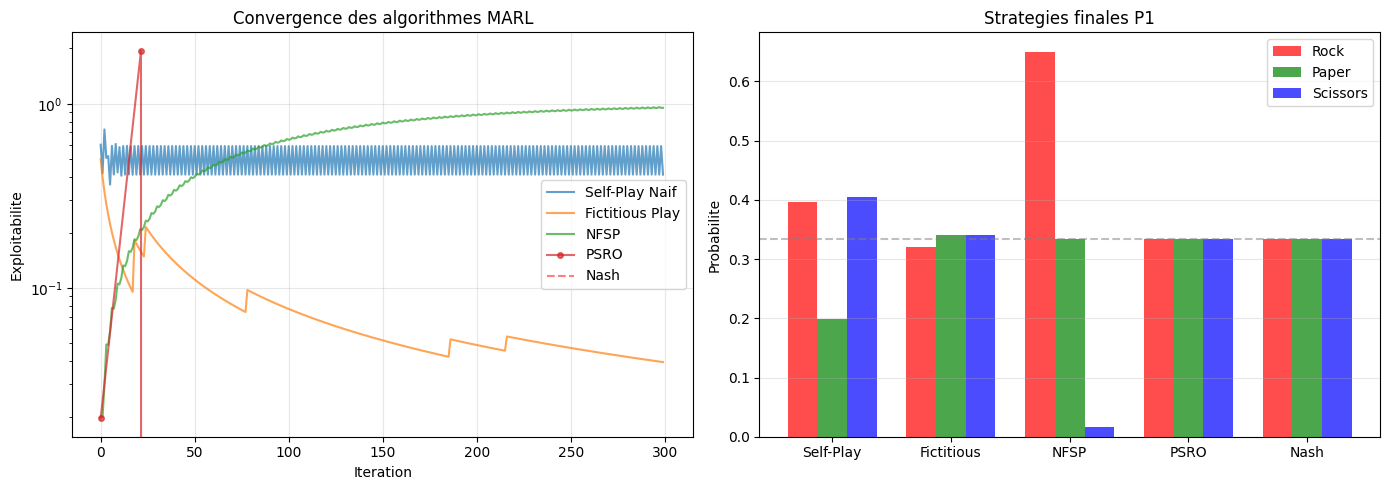


Recapitulatif:
Methode         Exploitabilite  Converge vers Nash?
---------------------------------------------
Self-Play Naif  0.4127          Non (cycles)
Fictitious Play 0.0396          Oui
NFSP            0.9510          Oui (approx)
PSRO            0.0000          Oui


In [7]:
# Comparaison finale de toutes les methodes
print("Comparaison des methodes MARL")
print("="*50)

# Reinitialiser et entrainer
n_iter = 300

sp_naive = NaiveSelfPlay(rps, learning_rate=0.3)
sp_naive.train(n_iter)

fp = FictitiousPlay(rps)
fp.train(n_iter)

nfsp = SimplifiedNFSP(rps, eta=0.1, rl_lr=0.05, sl_lr=0.01)
nfsp.train(n_iter)

psro = PSRO(rps)
psro.train(15)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Exploitabilite
ax1 = axes[0]
ax1.plot(sp_naive.history['exploitability'], label='Self-Play Naif', alpha=0.7)
ax1.plot(fp.history['exploitability'], label='Fictitious Play', alpha=0.7)
ax1.plot(nfsp.history['exploitability'], label='NFSP', alpha=0.7)

# PSRO a moins d'iterations, interpoler
psro_x = np.linspace(0, n_iter, len(psro.history['exploitability']))
ax1.plot(psro_x, psro.history['exploitability'], 'o-', label='PSRO', alpha=0.7, markersize=4)

ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Nash')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Exploitabilite')
ax1.set_title('Convergence des algorithmes MARL')
ax1.legend()
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Strategies finales
ax2 = axes[1]
methods = ['Self-Play', 'Fictitious', 'NFSP', 'PSRO', 'Nash']
strategies = [
    sp_naive.strategy_p1,
    fp.get_average_strategy(0),
    nfsp.avg_strategy_p1,
    psro.get_final_strategy()[0],
    np.array([1/3, 1/3, 1/3])
]

x = np.arange(len(methods))
width = 0.25
colors = ['red', 'green', 'blue']
labels = ['Rock', 'Paper', 'Scissors']

for i, (color, label) in enumerate(zip(colors, labels)):
    values = [s[i] for s in strategies]
    ax2.bar(x + (i - 1) * width, values, width, label=label, color=color, alpha=0.7)

ax2.axhline(y=1/3, color='gray', linestyle='--', alpha=0.5)
ax2.set_xticks(x)
ax2.set_xticklabels(methods)
ax2.set_ylabel('Probabilite')
ax2.set_title('Strategies finales P1')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('marl_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Tableau recapitulatif
print("\nRecapitulatif:")
print(f"{'Methode':<15} {'Exploitabilite':<15} {'Converge vers Nash?'}")
print("-"*45)
print(f"{'Self-Play Naif':<15} {sp_naive.history['exploitability'][-1]:<15.4f} {'Non (cycles)'}")
print(f"{'Fictitious Play':<15} {fp.history['exploitability'][-1]:<15.4f} {'Oui'}")
print(f"{'NFSP':<15} {nfsp.history['exploitability'][-1]:<15.4f} {'Oui (approx)'}")
print(f"{'PSRO':<15} {psro.history['exploitability'][-1]:<15.4f} {'Oui'}")

## 6. OpenSpiel : MARL a Grande Echelle

OpenSpiel fournit des implementations optimisees de ces algorithmes.

Optional module pokerkit_wrapper was not importable: No module named 'pokerkit'
Fictitious Play (OpenSpiel) sur Kuhn Poker
  Iter    0: exploitability = 0.458333
  Iter   10: exploitability = 0.083333
  Iter   50: exploitability = 0.031863
  Iter  100: exploitability = 0.023927
  Iter  200: exploitability = 0.015962
  Iter  500: exploitability = 0.009647
  Iter 1000: exploitability = 0.006702


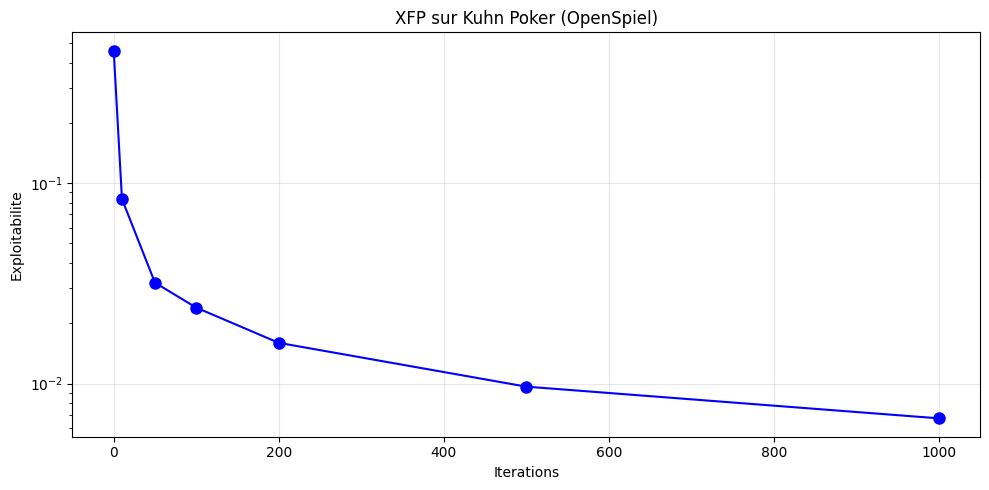

In [8]:
if OPENSPIEL_AVAILABLE:
    from open_spiel.python.algorithms import fictitious_play
    from open_spiel.python.algorithms import exploitability as expl_module
    from open_spiel.python import rl_environment

    # Charger Kuhn Poker
    game = pyspiel.load_game("kuhn_poker")

    print("Fictitious Play (OpenSpiel) sur Kuhn Poker")
    print("="*50)

    # XFP = extensive-form fictitious play
    xfp_solver = fictitious_play.XFPSolver(game)

    exploitabilities = []
    iterations = [0, 10, 50, 100, 200, 500, 1000]

    current_iter = 0
    for target in iterations:
        while current_iter < target:
            xfp_solver.iteration()
            current_iter += 1

        # L'API XFPSolver n'a pas de methode exploitability() directe
        # On utilise le module exploitability avec average_policy()
        avg_policy = xfp_solver.average_policy()
        conv = expl_module.exploitability(game, avg_policy)
        exploitabilities.append(conv)
        print(f"  Iter {target:>4}: exploitability = {conv:.6f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, exploitabilities, 'bo-', markersize=8)
    plt.xlabel('Iterations')
    plt.ylabel('Exploitabilite')
    plt.title('XFP sur Kuhn Poker (OpenSpiel)')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('xfp_kuhn_openspiel.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("OpenSpiel requis pour cette section")

## 7. AlphaZero : Self-Play + MCTS

### 7.1 Architecture

AlphaZero combine :
1. **Reseau de neurones** $f_\theta(s) \to (p, v)$ : politique + valeur
2. **Monte Carlo Tree Search (MCTS)** : recherche guidee par le reseau
3. **Self-play** : generation de donnees d'entrainement

### 7.2 Boucle d'entrainement

```
for iteration in range(N):
    # 1. Self-play avec MCTS
    games = []
    for _ in range(M):
        game = play_game_with_mcts(network)
        games.append(game)
    
    # 2. Entrainer le reseau
    for (state, mcts_policy, outcome) in sample_from_games(games):
        loss = cross_entropy(network.policy(state), mcts_policy) + 
               mse(network.value(state), outcome)
        network.update(loss)
```

### 7.3 Resultats

- **AlphaGo Zero** : a battu AlphaGo (qui avait battu Lee Sedol) en partant de zero
- **AlphaZero** : Generalisation a echecs et shogi, surpassant Stockfish/Elmo

In [9]:
# Schema conceptuel d'AlphaZero
print("Architecture AlphaZero (conceptuel)")
print("="*50)

alphazero_diagram = """
+------------------+
|   Self-Play      |<---------------------------+
|   (MCTS guided   |                            |
|    by network)   |                            |
+--------+---------+                            |
         |                                      |
         | (s, pi_mcts, z)                      |
         v                                      |
+--------+---------+                            |
|  Replay Buffer   |                            |
+--------+---------+                            |
         |                                      |
         v                                      |
+--------+---------+     +------------------+   |
|   Neural Net     |     |      MCTS        |   |
|   f(s) -> (p,v)  |---->|   (search tree)  |---+
+------------------+     +------------------+

Loss = CrossEntropy(p, pi_mcts) + MSE(v, z) + L2(weights)
"""

print(alphazero_diagram)

print("\nElements cles:")
print("  1. Reseau unique pour politique ET valeur")
print("  2. MCTS utilise le reseau pour guider la recherche")
print("  3. Self-play genere les donnees d'entrainement")
print("  4. Pas de connaissances a priori (tabula rasa)")

print("\nAméliorations successives:")
print("  - AlphaGo (2016): supervision + RL + MCTS")
print("  - AlphaGo Zero (2017): self-play pur, un seul reseau")
print("  - AlphaZero (2018): generalisation multi-jeux")
print("  - MuZero (2020): modele appris de la dynamique")

Architecture AlphaZero (conceptuel)

+------------------+
|   Self-Play      |<---------------------------+
|   (MCTS guided   |                            |
|    by network)   |                            |
+--------+---------+                            |
         |                                      |
         | (s, pi_mcts, z)                      |
         v                                      |
+--------+---------+                            |
|  Replay Buffer   |                            |
+--------+---------+                            |
         |                                      |
         v                                      |
+--------+---------+     +------------------+   |
|   Neural Net     |     |      MCTS        |   |
|   f(s) -> (p,v)  |---->|   (search tree)  |---+
+------------------+     +------------------+

Loss = CrossEntropy(p, pi_mcts) + MSE(v, z) + L2(weights)


Elements cles:
  1. Reseau unique pour politique ET valeur
  2. MCTS utilise le resea

## 8. Exercices

### Exercice 1 : Biased Rock-Paper-Scissors

Testez les algorithmes sur un RPS biaise ou Rock bat Paper avec proba 0.6.

### Exercice 2 : Matching Pennies

Appliquez PSRO a Matching Pennies et analysez la population.

### Exercice 3 : Independent Q-Learning

Implementez Q-learning independant et montrez la non-stationnarite.

### Exercice 4 : Win Rate tracking

Modifiez NFSP pour tracker le win rate contre differents adversaires fixes.

In [10]:
# Espace pour les exercices

# Exercice 2 : PSRO sur Matching Pennies
print("Exercice 2 : PSRO sur Matching Pennies")
print("="*50)

mp = create_matching_pennies()
psro_mp = PSRO(mp)
psro_mp.train(8)

final_p1, final_p2 = psro_mp.get_final_strategy()
print(f"\nStrategie finale P1: {final_p1}")
print(f"Strategie finale P2: {final_p2}")
print(f"Equilibre theorique: [0.5, 0.5]")
print(f"Exploitabilite: {psro_mp.history['exploitability'][-1]:.6f}")

Exercice 2 : PSRO sur Matching Pennies

Strategie finale P1: [0.5 0.5]
Strategie finale P2: [0.5 0.5]
Equilibre theorique: [0.5, 0.5]
Exploitabilite: 0.000000


## 9. Resume et Points Cles

### Ce que nous avons appris

1. **Defis MARL** : non-stationnarite, credit assignment, equilibres multiples
2. **Self-play naif** : cycles, ne converge pas forcement
3. **Fictitious Play** : converge dans les jeux a somme nulle
4. **NFSP** : approximation neurale de Fictitious Play
5. **PSRO** : population de strategies + meta-equilibre
6. **AlphaZero** : MCTS + reseaux de neurones + self-play

### Comparaison des methodes

| Methode | Convergence | Complexite | Usage |
|---------|-------------|------------|-------|
| Self-play naif | Non garanti | Faible | Baseline |
| Fictitious Play | Somme nulle | Faible | Theorie |
| NFSP | Approximative | Moyenne | Poker |
| PSRO | Oui | Elevee | General |
| AlphaZero | Empirique | Tres elevee | Jeux parfaits |

### Applications recentes

- **Poker** : Libratus, Pluribus (CFR + NFSP)
- **Go/Echecs** : AlphaZero, KataGo
- **Strategos** : Diplomacy (Meta AI, 2022)
- **Starcraft** : AlphaStar (DeepMind, 2019)

---

**Notebooks suivants** : Serie Lean 4 pour les formalisations (Notebooks 16-19)